# Explained features by intensity quartiles

Get khipus using updated grid,
Add new list of fragments
- Collect features that are explained;
- and numbers of unique empCpds

Plot how they overlap by each incremental quartile of features.

The candidate fragments are based on frequent delta m/zs. 

Not using those from MS2 as the freq lists here should be more inclusive.

Will move the frequent lists and top ones into mass2chem and khipu packages.

In [2]:
import io
import sys
import json
import tqdm
import contextlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from khipu.extended import peaklist_to_khipu_list, export_empCpd_khipu_list
sys.path.insert(0, '..')
from mining import * 
from isf_helper import (extract_ms2_spectrum, 
                        get_comprehensive_stats_per_dataset, 
                        explain_a_dataset_by_mz_deltas, 
                        explain_a_dataset_byMS2)

VERSION = '2_1'
dir_fig_output = f'../fig_for_pub/{VERSION}/orbi/'
os.makedirs(dir_fig_output, exist_ok=True)

In [3]:
hmdb_ms = json.load(open('hmdb_metabolites.json', 'r'))
hmdb_for_cpr = [{'id': m['primary_id'], 'rtime': 0, 'mz': float(m['monisotopic_molecular_weight'])} for m in hmdb_ms if m['monisotopic_molecular_weight']]

In [4]:
# Input data 

orbi_datasets = [x.rstrip() for x in open('selected_45_orbi_datasets.txt').readlines()]
pos_orbi_datasets = [x for x in orbi_datasets if 'pos' in x]
neg_orbi_datasets = [x for x in orbi_datasets if 'neg' in x]

# dict_tablefiles = {}
# for line in open('list_input_files.tsv').readlines():
#     a = line.rstrip().split('\t')
#     dict_tablefiles[a[0]] = a[1]

dict_rtwindow = {}
for line in open('elution_parameters_45studies_orbi.tsv').readlines()[1:]:
    a = line.rstrip().split('\t')
    dict_rtwindow[a[0]] = float(a[5])

In [5]:
# pos ionization
isotope_search_patterns_pos = [ (1.003355, '13C/12C', (0, 0.8)),
                            (2.00671, '13C/12C*2', (0, 0.8)),
                            (3.010065, '13C/12C*3', (0, 0.8)),
                            # (3.9948, '44Ca/40Ca', (0, 0.1)), # 2%
                            (1.9970, '37Cl/35Cl', (0.1, 0.8)), # 24.24%
                            ]

isotope_search_patterns_neg = [ (1.003355, '13C/12C', (0, 0.8)),
                            (2.00671, '13C/12C*2', (0, 0.8)),
                            (3.010065, '13C/12C*3', (0, 0.8)),
                            (1.9970, '37Cl/35Cl', (0.1, 0.8)), # 24.24%
                            (1.9958, '32S/34S', (0, 0.1)), # 4%
                            ]

adduct_search_patterns_pos = [  # initial patterns are relative to M+H+
                            (21.98194, 'Na/H'),
                            (41.026549, 'ACN'),     # Acetonitrile
                            (67.987424, 'NaCOOH'),
                            (37.955882, 'K/H'),
                            (32.026215, 'CH3OH')
                            ]
adduct_search_patterns_neg = [  
                            (21.98194, 'Na/H'), 
                            (67.987424, 'NaCOOH'),
                            (82.0030, 'NaCH2COOH'),
                            # (1.99566, 'F <-> OH'), 
                            (41.026549, 'ACN'),
                            (37.955882, 'K/H'),
                            ]
extended_adducts = [  # excluding neutral loss here; include as a step after khipu
                            (1.0078, 'H'),
                            (17.02655, 'NH3'),
                            (18.0106, 'H2O'),      # easy to confuse with bio reactions
                            (18.033823, 'NH4'),
                            (27.01089904, 'HCN'),
                            (27.99492, 'CO'),
                            (32.026215, 'CH3OH'),
                            (35.9767, 'HCl'),
                            (37.94694, 'Ca/H2'),
                            (43.96389, 'Na2/H2'),
                            (46.00548, 'CO2H2'),
                            (67.987424, 'NaCOOH'),
                            (83.961361, 'KCOOH'),
                            (97.96737927, 'H2SO4'),
                            (97.97689507, 'H3PO4'),
]

pos_candidate_fragments = '''14.0155	900	14.015649	addition of acetic acid and loss of CO2. Reaction: (+C2H2O2) and (-CO2)	{'C': 1, 'H': 2}
18.0104	885	18.010565	water	{'H': 2, 'O': 1}
2.0155	717	2.01565	± 2H, opening or forming of double bond	{'H': 2}
44.0261	652	44.0262	hydroxyethylation	{'C': 2, 'H': 4, 'O': 1}
28.0312	621	28.0313	± C2H4, natural alkane chains such as fatty acids	{'C': 2, 'H': 4}
15.9948	479	15.9949	oxidation	{'O': 1}
17.0264	451	17.0265	addition of ammonia. Reaction: (+NH3)	{'N': 1, 'H': 3}
26.0155	440	26.01565	acetylation and loss of oxygen. Reaction: (+C2H2O) and (-O)	{'C': 2, 'H': 2}
27.9947	433	27.9949	addition of CO. Reaction: (+CO)	{'C': 1, 'O': 1}
11.9999	426	12.0	methylation and reduction	{'C': 1}
42.0104	340	42.010564	malonylation and loss of CO2. Reaction: (+C3H2O3) and (-CO2)	{'C': 2, 'H': 2, 'O': 1}
67.9872	325	67.987424	NaCOOH	{'C': 1, 'O': 2, 'Na': 1, 'H': 1}
13.9791	321	13.979264	nitrification and loss of oxygen. Reaction: (NH2 -> NO2) and (-O)	{'H': -2, 'O': 1}
23.9998	317	24.0	acetylation and loss of water. Reaction: (+C2H2O) and (-H2O)	{'C': 2}
16.0312	314	16.0313	Methylation + reduction	{'C': 1, 'H': 4}
42.0468	314	42.04695	± C3H6, propylation	{'C': 3, 'H': 6}
46.0053	313	46.005305	formic acid adduct	{'C': 1, 'H': 2, 'O': 2}
88.0522	304	88.052429	butanoic acid	{'C': 4, 'H': 8, 'O': 2}
41.0263	295	41.026549	Acetonitrile	{'C': 2, 'H': 3, 'N': 1}
30.0468	267	30.04695	addition of C2H4 and hydrogenation. Reaction: (+C2H4) and (+H2)	{'C': 2, 'H': 6}
35.037	157	35.037114	addition of water and addition of ammonia. Reaction: (+H2O) and (+NH3)	{'H': 5, 'N': 1, 'O': 1}
'''
pos_candidate_fragments = [
    (float(x.split()[0]), x) for x in pos_candidate_fragments.splitlines()
]
pos_isf_candidate_fragments = [x[0] for x in pos_candidate_fragments]

In [6]:
def assign_intensity_quartile(list_features):
    '''
    example feature : {'id_number': 'F101',
                'id': 'F101',
                'mz': 113.8853,
                'rtime': 261.81,
                'apex': 261.81,
                'left_base': 261.02,
                'right_base': 263.65,
                'parent_masstrack_id': '1034',
                'peak_area': '433995',
                'cSelectivity': '0.75',
                'goodness_fitting': '0.98',
                'snr': '3',
                'detection_counts': '39',
                'representative_intensity': '433995'}
    returns dict {fid: quartile, ...}
    '''
    for f in list_features:
        f['peak_area'] = float(f['peak_area'])
    d = {}
    intensities = np.array([f['peak_area'] for f in list_features])
    x1, x2, x3 = np.quantile(intensities, 0.75
                        ), np.quantile(intensities, 0.5
                         ), np.quantile(intensities, 0.25)
    
    for f in list_features:
        if f['peak_area'] > x1:
            d[f['id']] = 1  # 1st quartile
        elif x1 >= f['peak_area'] > x2:
            d[f['id']] = 2
        elif x2 >= f['peak_area'] > x3:
            d[f['id']] = 3
        else:
            d[f['id']] = 4
    return d

In [7]:


# Detailed explanation of features by khipus and frequent deltas
# **Include feature intensity ranks**
# ~ 50 minutes

tally_pos = []
quartile_matches_pos = {}
unique_kp_ids_pos = {}
for study in tqdm.tqdm(pos_orbi_datasets):
    with contextlib.redirect_stdout(io.StringIO()):
        ion_mode = 'pos'
        _n, list_features = read_features_from_asari_table(
            open(f'../input_data_orbi/{study}/full_feature_table.tsv').read()
            )
        for f in list_features:
            f['representative_intensity'] = f['peak_area']
        list_khipus, all_assigned_fids = peaklist_to_khipu_list(
                                list_features, 
                                isotope_search_patterns=isotope_search_patterns_pos, 
                                adduct_search_patterns=adduct_search_patterns_pos,
                                extended_adducts=extended_adducts, 
                                mz_tolerance_ppm=5,
                                rt_tolerance=dict_rtwindow[study],
                                mode=ion_mode,
                                charges=[1, 2, 3],
                                )
    
        # convert khipu instances to dicts
        list_khipus = sorted(export_empCpd_khipu_list(list_khipus), 
                            key=lambda x: x['neutral_formula_mass'], reverse=True)
        fids_in_khipus = set([f['id'] for kp in list_khipus for f in kp['MS1_pseudo_Spectra']])
        remaining_features = [f for f in list_features if f['id'] not in fids_in_khipus]
        kp_ids = set(kp['interim_id'] for kp in list_khipus)
        
        # by isf_candidate_fragments
        explained_khipu_ids, explained_feature_ids, delta_values_used = explain_a_dataset_by_mz_deltas(
            list_khipus, remaining_features, pos_isf_candidate_fragments, 
            rt_stdev=dict_rtwindow[study]
            )

        dict_intensity_quartile = assign_intensity_quartile(list_features)
        preannotated_feature_ids = set(list(fids_in_khipus) + explained_feature_ids)
        quartile_matches = [dict_intensity_quartile[x] for x in preannotated_feature_ids]

        cur_tally = {
                'study': study,
                'num_khipus': len(list_khipus),
                'num_features':  len(list_features),
                'mzdelta_explained_khipus': len(set(explained_khipu_ids)), 
                'mzdelta_explained_features': len(set(explained_feature_ids)),
                'quartile_matches': quartile_matches,
            }
        tally_pos.append(cur_tally)
        
        M0_ids = [f['id'] for kp in list_khipus for f in kp['MS1_pseudo_Spectra'] if f['isotope'] == 'M0']
        isotope_ids = [f['id'] for kp in list_khipus for f in kp['MS1_pseudo_Spectra'] if f['isotope'] != 'M0']
        fragment_ids = explained_feature_ids
        singleton_ids = [f['id'] for f in remaining_features if f['id'] not in fragment_ids]
        
        quartile_matches_pos[study] = {
            'M0': [dict_intensity_quartile[x] for x in M0_ids],
            'isotope': [dict_intensity_quartile[x] for x in isotope_ids],
            'fragment': [dict_intensity_quartile[x] for x in fragment_ids],
            'singletons': [dict_intensity_quartile[x] for x in singleton_ids],
        }
        unique_kp_ids_pos[study] = list(kp_ids - set(explained_khipu_ids))
        os.makedirs(f'output/{VERSION}/pos/{study}', exist_ok=True)
        json.dump(list_khipus, open(f'output/{VERSION}/pos/{study}/ecpds.json', 'w'))
        json.dump(cur_tally, open(f'output/{VERSION}/pos/{study}/tally.json', 'w'))
        json.dump(quartile_matches_pos[study], open(f'output/{VERSION}/pos/{study}/quartile_matches.json', 'w'))

100%|██████████| 22/22 [48:14<00:00, 131.58s/it] 


In [14]:
test0 = tally_pos[0]['quartile_matches']
tally_pos[0]['num_features'], [
    len([x for x in test0 if x ==1]), len([x for x in test0 if x ==2]), 
    len([x for x in test0 if x ==3]), len([x for x in test0 if x ==4]),
]

(57875, [9315, 4613, 1917, 913])

In [15]:
# Get numbers of features explained by pre-annotation (= len(quartile_matches)), 
# and unique empCpds (= num_khipus - mzdelta_explained_khipus)
# 
# fig3a
preannotated_features = [len(x['quartile_matches']) for x in tally_pos]
unique_empCpds = [x['num_khipus']-x['mzdelta_explained_khipus'] for x in tally_pos]

#fig3b
quartile_percs_pos_all_preannotated = [[], [], [], []]
quartile_percs_pos = {'M0': [[], [], [], []], 
                      'isotope': [[], [], [], []], 
                      'fragment': [[], [], [], []], 
                      'singletons': [[], [], [], []], }
for x in tally_pos:
    list_q = x['quartile_matches']
    quartile_size = x['num_features']/4
    for type, q in quartile_matches_pos[x['study']].items():
        for ii in range(4):
            quartile_percs_pos[type][ii].append(100 * len([y for y in q if y==ii+1]) / quartile_size)
            # Use all preannotated features for violin plot
            quartile_percs_pos_all_preannotated[ii].append(100 * len([y for y in list_q if y==ii+1]) / quartile_size)

median_perc_pos = {}
for type, qpp in quartile_percs_pos.items():
    median_perc_pos[type] = [np.mean(qpp[ii]) for ii in range(4)]
median_perc_pos

{'M0': [34.772165025041794,
  16.840757124587896,
  10.362141822244114,
  6.6776377423962945],
 'isotope': [21.100582685154475,
  12.805648769876614,
  7.4113146800604595,
  3.946585634237852],
 'fragment': [3.200351553339885,
  2.515948291020583,
  1.3406805138995803,
  0.6249190466730477],
 'singletons': [40.92804771488573,
  67.83327289621334,
  80.88495550935833,
  88.75499099100999]}

In [16]:
# calculate overall explainable result across quartiles
for type, qpp in quartile_percs_pos.items():
    print(np.mean(qpp))

17.163175428567524
11.316032942332349
1.920474851233274
69.60031677786685


In [17]:
unique_kp_mass_pos = {}
for study_id, kp_ids in unique_kp_ids_pos.items():
    list_khipus = json.load(open(f'output/{VERSION}/pos/{study_id}/ecpds.json', 'r'))
    dict_khipus = {kp['interim_id']: kp for kp in list_khipus}
    unique_kp_mass_pos[study_id] = [{'mz': dict_khipus[kp_id]['neutral_formula_mass'], 'id': kp_id, 'rtime': 0} for kp_id in kp_ids]
unique_kp_matched_pos = [len(mf.list_match_lcms_features(kp_masses, hmdb_for_cpr, mz_ppm=5, rt_tolerance=1E20)) for _, kp_masses in unique_kp_mass_pos.items()]

Of 5505 list1 features, number of uni-direction matched features is 2182.
Of 18263 list1 features, number of uni-direction matched features is 5825.
Of 10055 list1 features, number of uni-direction matched features is 3171.
Of 6767 list1 features, number of uni-direction matched features is 2209.
Of 11559 list1 features, number of uni-direction matched features is 2063.
Of 6439 list1 features, number of uni-direction matched features is 2093.
Of 5575 list1 features, number of uni-direction matched features is 1166.
Of 3391 list1 features, number of uni-direction matched features is 928.
Of 3661 list1 features, number of uni-direction matched features is 1337.
Of 5840 list1 features, number of uni-direction matched features is 2050.
Of 2034 list1 features, number of uni-direction matched features is 531.
Of 1700 list1 features, number of uni-direction matched features is 726.
Of 4690 list1 features, number of uni-direction matched features is 1555.
Of 2266 list1 features, number of uni-

16601.0 5540.0 1871.0


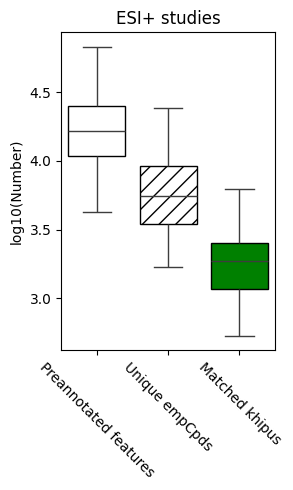

In [18]:

# Fig 3a. preannotated_features unique_empCpds
_d = {
    'Preannotated features': np.log10(preannotated_features),
    'Unique empCpds': np.log10(unique_empCpds),
    'Matched khipus': np.log10(unique_kp_matched_pos)
}
from matplotlib.ticker import FormatStrFormatter

print(np.median(preannotated_features), np.median(unique_empCpds), np.median(unique_kp_matched_pos))

fig, ax = plt.subplots(1, 1, figsize=(3, 5))
boxplot = sns.boxplot(data=_d, width=0.8)
for i, patch in enumerate(boxplot.patches):
    hatch = "" if i % 2 == 0 else "//"  # Different hatches for alternating boxes
    patch.set_hatch(hatch)
    patch.set_edgecolor('black')  # Set border color
    if i != 2:
        patch.set_facecolor('white')  
    else:
        patch.set_facecolor('green')

ax.tick_params(axis='x', rotation=315)
ax.set_ylabel("log10(Number)")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Format y-axis with 2 decimal places
ax.set_title("ESI+ studies")
plt.tight_layout()
plt.savefig(f"2f_1_preannotation_pos.pdf")

Of 5505 list1 features, number of uni-direction matched features is 2182.
Of 18263 list1 features, number of uni-direction matched features is 5825.
Of 10055 list1 features, number of uni-direction matched features is 3171.
Of 6767 list1 features, number of uni-direction matched features is 2209.
Of 11559 list1 features, number of uni-direction matched features is 2063.
Of 6439 list1 features, number of uni-direction matched features is 2093.
Of 5575 list1 features, number of uni-direction matched features is 1166.
Of 3391 list1 features, number of uni-direction matched features is 928.
Of 3661 list1 features, number of uni-direction matched features is 1337.
Of 5840 list1 features, number of uni-direction matched features is 2050.
Of 2034 list1 features, number of uni-direction matched features is 531.
Of 1700 list1 features, number of uni-direction matched features is 726.
Of 4690 list1 features, number of uni-direction matched features is 1555.
Of 2266 list1 features, number of uni-

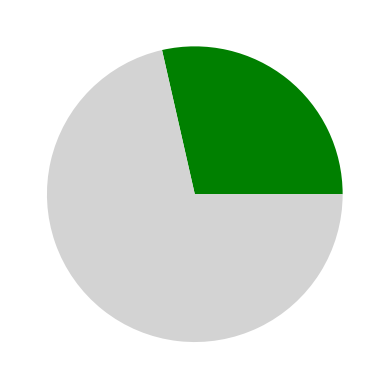

In [19]:
# draw piechart
matched_total_pairs = [(len(mf.list_match_lcms_features(kp_masses, hmdb_for_cpr, mz_ppm=5, rt_tolerance=1E20)), len(kp_masses)) for _, kp_masses in unique_kp_mass_pos.items()]
fig, axs = plt.subplots(1, 1)
fig.set_figwidth(10)
axs.pie((sum([mtp[0] for mtp in matched_total_pairs]), sum([mtp[1] - mtp[0] for mtp in matched_total_pairs])), colors=['green', 'lightgray']) # radia[ii]
plt.savefig("2g_1_matched_neutral_mass_pos.pdf")

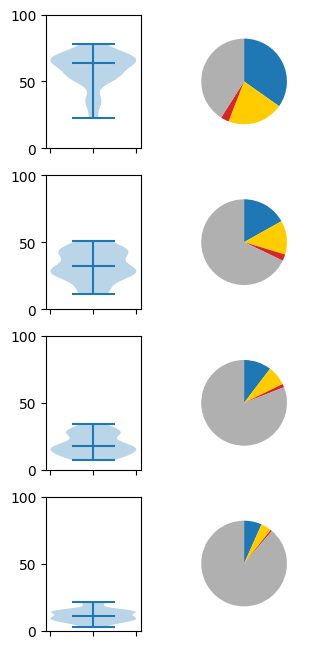

In [10]:

# Fig. 3b. distribution of perc; pie chart for median pec

piedata = [(median_perc_pos['M0'][i], median_perc_pos['isotope'][i], 
            median_perc_pos['fragment'][i], median_perc_pos['singletons'][i]) for i in range(4)]

colors = ['#1f77b4', '#ffcc00', '#d62728', '#b0b0b0']  # Blue, Yellow, Red, Grey

fig, axs = plt.subplots(4, 2, figsize=(5, 8), gridspec_kw={'wspace': 0.05}) 


for ii in range(4):
    parts = axs[ii, 0].violinplot(
        quartile_percs_pos_all_preannotated[ii],
        showmedians=True,
        showextrema=True
    )
    axs[ii, 0].set_yticks([0, 50, 100])
    axs[ii, 0].tick_params(axis='x', which='both', bottom=True, labelbottom=False)  # Hide tick labels but keep ticks
    
    # Adjust the width of the violin plot (axs[ii, 0])
    pos = axs[ii, 0].get_position()  # Get current position of the violin plot
    axs[ii, 0].set_position([pos.x0 + 0.05, pos.y0, pos.width * 0.5, pos.height])  # Make it 50% narrower


    axs[ii, 1].pie(
        piedata[ii], 
        colors=colors, 
        radius=0.8, 
        startangle=90, 
        counterclock=False,
        # autopct='%1.1f%%'
        )
    # axs[ii].set_title(f"{(ii)*25}% - {(ii + 1)*25}%") 
    
    pos_pie = axs[ii, 1].get_position()  # Get current position of the pie chart
    axs[ii, 1].set_position([pos_pie.x0 - 0.14, pos_pie.y0, pos_pie.width, pos_pie.height])  
    
plt.tight_layout()
plt.savefig(f"{dir_fig_output}/Fig3b_preannotation_pos_piecharts.pdf")


In [11]:
piedata

[(34.78278697813586, 21.09983548567375, 3.147120191200173, 40.97140432341209),
 (16.8562028146978, 12.810180592646248, 2.460353868106725, 67.8688898062477),
 (10.356660041149821,
  7.407032734232415,
  1.3137287902723147,
  80.92167095990793),
 (6.677071149524175,
  3.9511294993983928,
  0.6196655715068454,
  88.75626719388775)]

## Do neg ion studies

In [20]:
neg_candidate_fragments = '''67.9874	819	67.987424	NaCOOH	"{'C': 1, 'O': 2, 'Na': 1, 'H': 1}"
14.0156	693	14.015649	addition of acetic acid and loss of CO2. Reaction: (+C2H2O2) and (-CO2)	"{'C': 1, 'H': 2}"
2.0155	570	2.01565	"± 2H, opening or forming of double bond"	{'H': 2}
82.0029	431	82.003035	methylation and addition of trifluoromethyl. Reaction: (+CH2) and (+CF3-H)	"{'C': 2, 'H': 1, 'F': 3}"
15.9948	415	15.9949	oxidation	{'O': 1}
43.9898	394	43.9898	addition of CO2. Reaction: (+CO2)	"{'C': 1, 'O': 2}"
18.0105	374	18.010565	water	"{'H': 2, 'O': 1}"
11.9999	359	12	methylation and reduction	{'C': 1}
30.0105	352	30.010564	addition of acetic acid and loss of CO. Reaction: (+C2H2O2) and (-CO)	"{'C': 1, 'H': 2, 'O': 1}"
26.0156	346	26.01565	acetylation and loss of oxygen. Reaction: (+C2H2O) and (-O)	"{'C': 2, 'H': 2}"
46.0054	339	46.005479	formic acid adduct	"{'C': 1, 'H': 2, 'O': 2}"
28.0312	327	28.0313	"± C2H4, natural alkane chains such as fatty acids"	"{'C': 2, 'H': 4}"
44.0261	303	44.0262	hydroxyethylation	"{'C': 2, 'H': 4, 'O': 1}"
27.9949	297	27.9949	addition of CO. Reaction: (+CO)	"{'C': 1, 'O': 1}"
23.9999	265	24	acetylation and loss of water. Reaction: (+C2H2O) and (-H2O)	{'C': 2}
13.9792	256	13.979264	nitrification and loss of oxygen. Reaction: (NH2 -> NO2) and (-O)	"{'H': -2, 'O': 1}"
42.0105	250	42.010564	malonylation and loss of CO2. Reaction: (+C3H2O3) and (-CO2)	"{'C': 2, 'H': 2, 'O': 1}"
16.0312	239	16.0313	Methylation + reduction	"{'C': 1, 'H': 4}"
60.021	229	-60.0211	desmolysis	"{'C': -2, 'H': -4, 'O': -2}"
135.9748	222	135.974848	2X NaCOOH	"{'C': 2, 'O': 4, 'H': 2, 'Na': 2}"
'''
neg_candidate_fragments = [
    (float(x.split()[0]), x) for x in neg_candidate_fragments.splitlines()
]

isf_candidate_fragments_neg = [x[0] for x in neg_candidate_fragments]

In [21]:


# Detailed explanation of features by khipus and frequent deltas
# **Include feature intensity ranks**
# ~ 70 minutes

tally_neg = []
quartile_matches_neg = {}
unique_kp_ids_neg = {}
for study in tqdm.tqdm(neg_orbi_datasets):
    with contextlib.redirect_stdout(io.StringIO()):
        ion_mode = 'neg'
        _n, list_features = read_features_from_asari_table(
            open(f'../input_data_orbi/{study}/full_feature_table.tsv').read()
            )
        for f in list_features:
            f['representative_intensity'] = f['peak_area']
        list_khipus, all_assigned_fids = peaklist_to_khipu_list(
                                list_features, 
                                isotope_search_patterns=isotope_search_patterns_neg, 
                                adduct_search_patterns=adduct_search_patterns_neg,
                                extended_adducts=extended_adducts, 
                                mz_tolerance_ppm=5,
                                rt_tolerance=dict_rtwindow[study],
                                mode=ion_mode,
                                charges=[1, 2, 3],
                                )

        # convert khipu instances to dicts
        list_khipus = sorted(export_empCpd_khipu_list(list_khipus), 
                            key=lambda x: x['neutral_formula_mass'], reverse=True)
        fids_in_khipus = set([f['id'] for kp in list_khipus for f in kp['MS1_pseudo_Spectra']])
        remaining_features = [f for f in list_features if f['id'] not in fids_in_khipus]
        kp_ids = set(kp['interim_id'] for kp in list_khipus)
        
        # by isf_candidate_fragments
        explained_khipu_ids, explained_feature_ids, delta_values_used = explain_a_dataset_by_mz_deltas(
            list_khipus, remaining_features, isf_candidate_fragments_neg, 
            rt_stdev=dict_rtwindow[study]
            )

        dict_intensity_quartile = assign_intensity_quartile(list_features)
        preannotated_feature_ids = set(list(fids_in_khipus) + explained_feature_ids)
        quartile_matches = [dict_intensity_quartile[x] for x in preannotated_feature_ids]
        
        unique_kp_ids_neg[study] = list(kp_ids - set(explained_khipu_ids))

        cur_tally = {
                'study': study,
                'num_khipus': len(list_khipus),
                'num_features':  len(list_features),
                'mzdelta_explained_khipus': len(set(explained_khipu_ids)), 
                'mzdelta_explained_features': len(set(explained_feature_ids)),
                'quartile_matches': quartile_matches,
            }
        tally_neg.append(cur_tally)
        
        M0_ids = [f['id'] for kp in list_khipus for f in kp['MS1_pseudo_Spectra'] if f['isotope'] == 'M0']
        isotope_ids = [f['id'] for kp in list_khipus for f in kp['MS1_pseudo_Spectra'] if f['isotope'] != 'M0']
        fragment_ids = explained_feature_ids
        singleton_ids = [f['id'] for f in remaining_features if f['id'] not in fragment_ids]
        
        quartile_matches_neg[study] = {
            'M0': [dict_intensity_quartile[x] for x in M0_ids],
            'isotope': [dict_intensity_quartile[x] for x in isotope_ids],
            'fragment': [dict_intensity_quartile[x] for x in fragment_ids],
            'singletons': [dict_intensity_quartile[x] for x in singleton_ids],
        }
        os.makedirs(f'output/{VERSION}/neg/{study}', exist_ok=True)
        json.dump(list_khipus, open(f'output/{VERSION}/neg/{study}/ecpds.json', 'w'))
        json.dump(cur_tally, open(f'output/{VERSION}/neg/{study}/tally.json', 'w'))
        json.dump(quartile_matches_neg[study], open(f'output/{VERSION}/neg/{study}/quartile_matches.json', 'w'))

100%|██████████| 23/23 [1:33:14<00:00, 243.25s/it]


In [22]:
# Get numbers of features explained by pre-annotation (= len(quartile_matches)), 
# and unique empCpds (= num_khipus - mzdelta_explained_khipus)
# 
# fig3a
preannotated_features = [len(x['quartile_matches']) for x in tally_neg]
unique_empCpds = [x['num_khipus']-x['mzdelta_explained_khipus'] for x in tally_neg]

#fig3b
quartile_percs_neg_all_preannotated = [[], [], [], []]
quartile_percs_neg = {'M0': [[], [], [], []], 
                      'isotope': [[], [], [], []], 
                      'fragment': [[], [], [], []], 
                      'singletons': [[], [], [], []], }
for x in tally_neg:
    list_q = x['quartile_matches']
    quartile_size = x['num_features']/4
    for type, q in quartile_matches_neg[x['study']].items():
        for ii in range(4):
            quartile_percs_neg[type][ii].append(100 * len([y for y in q if y==ii+1]) / quartile_size)
            # Use all preannotated features for violin plot
            quartile_percs_neg_all_preannotated[ii].append(100 * len([y for y in list_q if y==ii+1]) / quartile_size)


median_perc_neg = {}
for type, qpp in quartile_percs_neg.items():
    median_perc_neg[type] = [np.mean(qpp[ii]) for ii in range(4)]
median_perc_neg

{'M0': [33.924471387848556,
  16.706048219682128,
  11.200515415001101,
  7.844704964508597],
 'isotope': [21.752667313471537,
  13.702691822849522,
  8.720526219222828,
  5.052530205152494],
 'fragment': [3.2661034489273852,
  2.290092802154032,
  1.2901583976233395,
  0.6352812263184656],
 'singletons': [41.0575076515218,
  67.29772157823614,
  78.78716042350385,
  86.47181892397819]}

In [23]:
# calculate overall explainable result across quartiles
for type, qpp in quartile_percs_neg.items():
    print(np.mean(qpp))

17.4189349967601
12.307103890174096
1.870408968755806
68.40355214431


In [24]:
unique_kp_mass_neg = {}
for study_id, kp_ids in unique_kp_ids_neg.items():
    list_khipus = json.load(open(f'output/{VERSION}/neg/{study_id}/ecpds.json', 'r'))
    dict_khipus = {kp['interim_id']: kp for kp in list_khipus}
    unique_kp_mass_neg[study_id] = [{'mz': dict_khipus[kp_id]['neutral_formula_mass'], 'id': kp_id, 'rtime': 0} for kp_id in kp_ids]
unique_kp_matched_neg = [len(mf.list_match_lcms_features(kp_masses, hmdb_for_cpr, mz_ppm=5, rt_tolerance=1E20)) for _, kp_masses in unique_kp_mass_neg.items()]

Of 3103 list1 features, number of uni-direction matched features is 1009.
Of 11146 list1 features, number of uni-direction matched features is 3418.
Of 9840 list1 features, number of uni-direction matched features is 3013.
Of 3312 list1 features, number of uni-direction matched features is 594.
Of 3315 list1 features, number of uni-direction matched features is 1176.
Of 1988 list1 features, number of uni-direction matched features is 491.
Of 18127 list1 features, number of uni-direction matched features is 5511.
Of 13010 list1 features, number of uni-direction matched features is 3302.
Of 2335 list1 features, number of uni-direction matched features is 487.
Of 3266 list1 features, number of uni-direction matched features is 1736.
Of 14400 list1 features, number of uni-direction matched features is 3308.
Of 9095 list1 features, number of uni-direction matched features is 2321.
Of 14512 list1 features, number of uni-direction matched features is 5846.
Of 3020 list1 features, number of un

Of 3103 list1 features, number of uni-direction matched features is 1009.
Of 11146 list1 features, number of uni-direction matched features is 3418.
Of 9840 list1 features, number of uni-direction matched features is 3013.
Of 3312 list1 features, number of uni-direction matched features is 594.
Of 3315 list1 features, number of uni-direction matched features is 1176.
Of 1988 list1 features, number of uni-direction matched features is 491.
Of 18127 list1 features, number of uni-direction matched features is 5511.
Of 13010 list1 features, number of uni-direction matched features is 3302.
Of 2335 list1 features, number of uni-direction matched features is 487.
Of 3266 list1 features, number of uni-direction matched features is 1736.
Of 14400 list1 features, number of uni-direction matched features is 3308.
Of 9095 list1 features, number of uni-direction matched features is 2321.
Of 14512 list1 features, number of uni-direction matched features is 5846.
Of 3020 list1 features, number of un

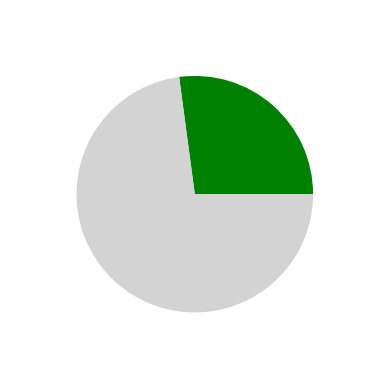

In [26]:
# draw piechart
matched_total_pairs = [(len(mf.list_match_lcms_features(kp_masses, hmdb_for_cpr, mz_ppm=5, rt_tolerance=1E20)), len(kp_masses)) for _, kp_masses in unique_kp_mass_neg.items()]
fig, axs = plt.subplots(1, 1)
fig.set_figwidth(10)
axs.pie((sum([mtp[0] for mtp in matched_total_pairs]), sum([mtp[1] - mtp[0] for mtp in matched_total_pairs])), colors=['green', 'lightgray'], radius=.8) # radia[ii]
plt.savefig("2g_2_matched_neutral_mass_neg.pdf")

16301.0 5956.0 1736.0


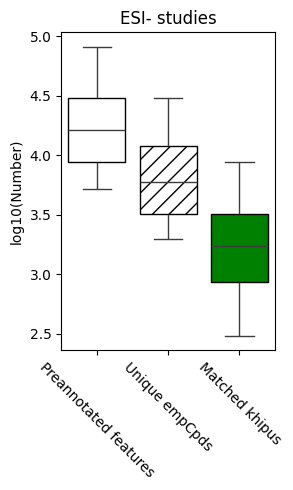

In [25]:

# Fig 3c. preannotated_features unique_empCpds
_d = {
    'Preannotated features': np.log10(preannotated_features),
    'Unique empCpds': np.log10(unique_empCpds),
    'Matched khipus': np.log10(unique_kp_matched_neg)
}
from matplotlib.ticker import FormatStrFormatter

print(np.median(preannotated_features), np.median(unique_empCpds), np.median(unique_kp_matched_neg))

fig, ax = plt.subplots(1, 1, figsize=(3, 5))
boxplot = sns.boxplot(data=_d, width=0.8)
for i, patch in enumerate(boxplot.patches):
    hatch = "" if i % 2 == 0 else "//"  # Different hatches for alternating boxes
    patch.set_hatch(hatch)
    patch.set_edgecolor('black')  # Set border color
    if i != 2:
        patch.set_facecolor('white')  
    else:
        patch.set_facecolor('green')
    
ax.tick_params(axis='x', rotation=315)
ax.set_ylabel("log10(Number)")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Format y-axis with 2 decimal places

ax.set_title("ESI- studies")
plt.tight_layout()
plt.savefig(f"2f_2_preannotation_pos.pdf")

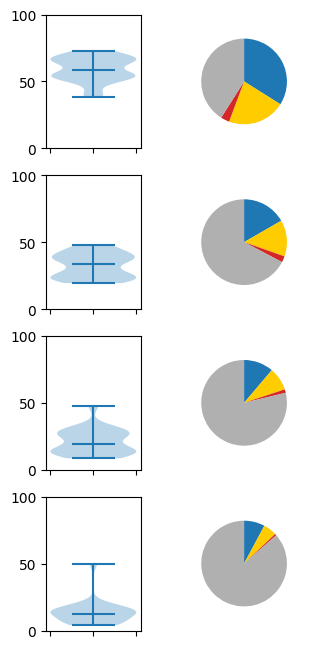

In [17]:

# Fig. 3b. distribution of perc; pie chart for median pec
piedata = [(median_perc_neg['M0'][i], median_perc_neg['isotope'][i], 
            median_perc_neg['fragment'][i], median_perc_neg['singletons'][i]) for i in range(4)]

colors = ['#1f77b4', '#ffcc00', '#d62728', '#b0b0b0']  # Blue, Yellow, Red, Grey

fig, axs = plt.subplots(4, 2, figsize=(5, 8), gridspec_kw={'wspace': 0.05}) 


for ii in range(4):
    parts = axs[ii, 0].violinplot(
        quartile_percs_neg_all_preannotated[ii],
        showmedians=True,
        showextrema=True
    )
    axs[ii, 0].set_yticks([0, 50, 100])
    axs[ii, 0].tick_params(axis='x', which='both', bottom=True, labelbottom=False)  # Hide tick labels but keep ticks
    
    # Adjust the width of the violin plot (axs[ii, 0])
    pos = axs[ii, 0].get_position()  # Get current position of the violin plot
    axs[ii, 0].set_position([pos.x0 + 0.05, pos.y0, pos.width * 0.5, pos.height])  # Make it 50% narrower


    axs[ii, 1].pie(
        piedata[ii], 
        colors=colors, 
        radius=0.8, 
        startangle=90, 
        counterclock=False,
        # autopct='%1.1f%%'
        )
    # axs[ii].set_title(f"{(ii)*25}% - {(ii + 1)*25}%") 
    
    pos_pie = axs[ii, 1].get_position()  # Get current position of the pie chart
    axs[ii, 1].set_position([pos_pie.x0 - 0.14, pos_pie.y0, pos_pie.width, pos_pie.height])  
    
plt.tight_layout()
plt.savefig(f"{dir_fig_output}/Fig3b_preannotation_neg_piecharts.pdf")

In [18]:
piedata

[(33.9303967725246, 21.75020931429039, 3.301082144147459, 41.01906157080684),
 (16.687311216949073,
  13.704405974701155,
  2.313606785757304,
  67.29123044551429),
 (11.19069615840221, 8.720280632120154, 1.3052144552842435, 78.78216920954452),
 (7.843654435495609, 5.051371352332017, 0.6343129757463035, 86.47499655638381)]

# Conclusion

This notebook plots Figure 3. 

Numbers of pre-annotated features by extended khipus in 45 orbi studies.
a,b. Distribution of numbers of pre-annotated features, median value 16,574 and 16,296 for positive and negative ionization datasets, respectively. They correspond to 5,539 and 5,937 unique khipus, respectively.

 c,d. Percentage distribution of pre-annotated features in each intensity quartile in each study, for positive and negative ionization datasets, respectively. The pie charts show mean percentage in each quartile, respectively. 